In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='8eb31a7a-0d80-42e0-9bae-821e03d16e69', project_access_token='p-f211a0edf87dfd94217ac020cf38d50d79375322')
pc = project.project_context


# MARATONA BEHIND THE CODE 2020

## DESAFIO 4 - CompuSoluciones

### Introducción

En este desafío, CompuSoluciones usará herramientas de IBM como Watson Studio (o Cloud Pack for Data) y Watson Machine Learning para construir un modelo de Machine Learning natural capaz de predecir la probabilidad de cumplimiento de pago.

La idea esencial del Desafío 4 es crear un modelo basado en machine learning capaz de identificar el comportamiento financiero del asociado de negocio, permitiendo una probabilidad de cumplimiento o incumplimiento del crédito.

<hr>

### Instalación de Librerias

In [ ]:
!pip install scikit-learn==0.23.2 --upgrade

In [ ]:
!pip install pandas==1.1.1 --upgrade

In [ ]:
!pip install -U imbalanced-learn

In [2]:
import json
import requests
import pandas as pd
import numpy as np

from collections import Counter

from scipy import stats
from datetime import datetime

from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold

# Impputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

# imblearn
from imblearn.over_sampling import SMOTE

### Descargando el dataset csv desde Github

In [ ]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv

In [3]:
df = pd.read_csv(r'reto-4-compu-train.csv')
df.head()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,NaN,7.710800e+06,NaN,1.237449e+06,2.947057e+05,8.812520e+06,4.547214e+07,239671.50090,1.257907e+06,2356497.733,-6.009930e+06,-6.816681e+06,41309820.53,6.872572e+07,6298390.104,1.505762e+07,Aceptado
1,7.437098e+04,2.213116e+06,NaN,1.335531e+05,4.000109e+05,8.491851e+06,1.573254e+07,94809.20697,6.708985e+05,NaN,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,5.269987e+06,2.893119e+07,3.983352e+05,1.533061e+07,3.478673e+06,-1.393229e+07,NaN,610814.63990,1.009937e+07,1444426.243,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,9.092134e+05,1.145092e+07,9.577823e+06,1.068692e+06,1.302021e+06,1.379064e+06,NaN,NaN,2.378928e+06,1236065.779,NaN,-4.567435e+06,76310275.60,NaN,NaN,1.323267e+07,Aceptado
4,9.688669e+05,8.539206e+06,3.898283e+06,4.168733e+05,NaN,-6.297179e+05,7.620711e+06,116647.73960,1.798065e+06,3657339.603,7.702845e+05,-7.110320e+05,62901614.29,3.614260e+07,6850340.403,1.100048e+07,Aceptado


### Acerca del Dataset

Class 0: 8873
Class 1: 527
Proportion: 16.84 : 1


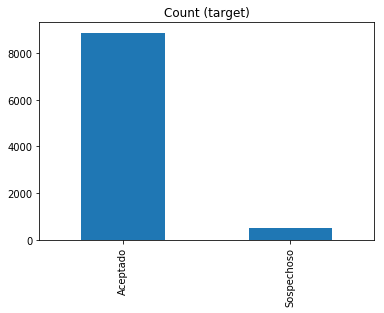

In [4]:
# df.info()

target_count = df.OBJETIVO.value_counts()
print('Class 0:', target_count['Aceptado'])
print('Class 1:', target_count['Sospechoso'])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [ ]:
df.info()

Las variables son todas numericas. Solo nuestra variable TARGET (Prestamo aprobado o posible incumplimiento financiero) es the tipo float.

La función describe() de abajo muestra varias estadisticas del dataset.

In [ ]:
df.describe()

<hr>

### Entrenamiento y evaluación de un modelo de clasificación binaria


#### Transformación 1: excluir columnas del conjunto de datos

Para la creación de una transformación de datos personalizada en scikit-learn, es necesario crear una clase con los métodos transform y fit. En el método de 'transform', se ejecutará la lógica de nuestra transformación.

La siguiente celda muestra el código completo de una transformación DropColumns para eliminar columnas de un pandas DataFrame.


In [5]:
# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        # Devolvemos un nuevo dataframe de datos sin las columnas no deseadas
        return data.drop(labels=self.columns, axis='columns')

# Clase para hacer UnderSampling

In [6]:
class UnderSamplingDataSet(BaseEstimator, TransformerMixin):
    def __init__(self, target):
        self.target = target

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = pd.DataFrame(X.copy())

        accepted_count, suspicious_count = data.value_counts([self.target])

        accepted_df = data[data[self.target] == 'Aceptado']
        suspicious_df = data[data[self.target] == 'Sospechoso']

        accepted_under_df = accepted_df.sample(suspicious_count, random_state=337, replace=True)
        return pd.concat([accepted_under_df, suspicious_df], axis=0)

# Mantener solo los datos con al menos 14 valores no nulos

In [7]:
df2 = df.dropna(thresh=14)

In [8]:
len(df2)

7397

Class 0: 6993
Class 1: 404
Proportion: 17.31 : 1


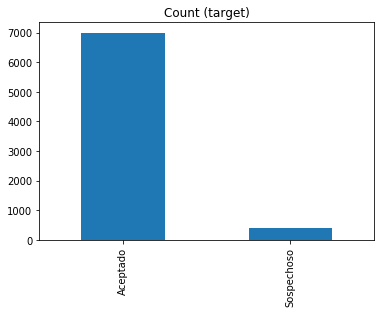

In [9]:
# df.info()

target_count = df2.OBJETIVO.value_counts()
print('Class 0:', target_count['Aceptado'])
print('Class 1:', target_count['Sospechoso'])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

# Eliminar las columnas no deseadas del dataset

In [10]:
# Creación de instancias de una transformación DropColumns
rm_columns = DropColumns(
    columns=["CXC", "CAP_SOCIAL"]  # Esta transformación toma como parámetro una lista con los nombres de las columnas no deseadas
)

print(rm_columns)

DropColumns(columns=['CXC', 'CAP_SOCIAL'])


In [11]:
# Ver las columnas del conjunto de datos original
#print("Columnas del conjunto de datos original: \n")
#print(df.columns)

# Aplicar la transformación ``DropColumns`` al conjunto de datos base
rm_columns.fit(X=df2)

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df2
    ),
)

# Ver las columnas del conjunto de datos transformado
#print("\n\nColumnas del conjunto de datos después de la transformación ``DropColumns``: \n")
#print(df2.columns)

In [12]:
len(df2)

7397

# Undersampling

In [13]:
baldata = UnderSamplingDataSet(target='OBJETIVO')

In [14]:
baldata.fit(X=df2)
#df_test_under = df_test.transform(X=df3)

df2 = pd.DataFrame.from_records(
    data=baldata.transform(
        X=df2
    )
)

Class 0: 404
Class 1: 404
Proportion: 1.0 : 1


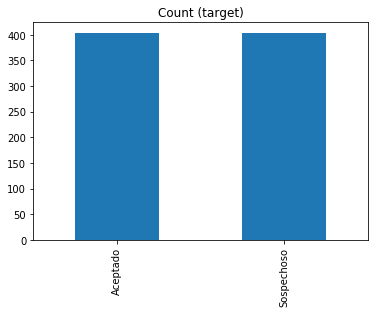

In [15]:
target_count = df2.OBJETIVO.value_counts()
print('Class 0:', target_count['Aceptado'])
print('Class 1:', target_count['Sospechoso'])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

#### Transformación 3: tratamiento de datos faltantes

Para manejar los datos que faltan en nuestro conjunto de datos, ahora usaremos una transformación lista para usar de la biblioteca scikit-learn, llamada SimpleImputer.

Esta transformación permite varias estrategias para el tratamiento de datos faltantes. La documentación oficial se puede encontrar en: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

En este ejemplo, simplemente haremos cero todos los valores faltante usted puede escoger otra estrategia ;).

In [16]:
objetivo = df2[['OBJETIVO']]
df_si = df2[np.array(df2.columns)[:-1]]
df_si.columns

Index(['EFECTIVO', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE',
       'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR',
       'ANTICIPOS_CTE', 'UTILIDADES_ACUMULADAS', 'UTILIDAD_O_PERDIDA',
       'TOTAL_VENTAS', 'TOTAL_COMPRAS', 'UTILIDAD_BRUTA', 'TOTAL_GASTOS'],
      dtype='object')

In [17]:
# Crear un objeto ``SimpleImputer``
imp_mean =  SimpleImputer(
    missing_values=np.nan,
    strategy='mean',
)

In [18]:
imp_mean.fit(X=df_si)

# Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df3 = pd.DataFrame.from_records(
    data=imp_mean.transform(
        X=df_si
    ),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=df_si.columns # las columnas originales deben conservarse en esta transformación
)

In [19]:
df3.insert(len(df3.columns), 'OBJETIVO', objetivo)

In [ ]:
df3.head()

#### Definición de features (Variables Independientes)

En este * ejemplo * usaremos todas las columnas. (Usted debe decidir cuales variables utilizar)

In [20]:
features = df3[
    np.array(df3.columns)[:-1]
]
target = df3["OBJETIVO"]

In [ ]:
target

#### División en 80% entrenamiento y 20% pruebas

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=337)

#### Entrenando un modelo ``DecisionTreeClassifier()``

In [22]:
dtc_model = ExtraTreesClassifier(n_estimators=100, max_features='auto', criterion='entropy', random_state=337, class_weight='balanced')
dtc_model.fit(X_train, y_train)

ExtraTreesClassifier(class_weight='balanced', criterion='entropy',
                     random_state=337)

In [26]:
dtc_model.feature_importances_

array([0.03387626, 0.0641803 , 0.02649704, 0.03459039, 0.17415367,
       0.03830557, 0.02969677, 0.05510665, 0.13231741, 0.22536215,
       0.05270129, 0.03479249, 0.05173349, 0.04668651])

<BarContainer object of 14 artists>

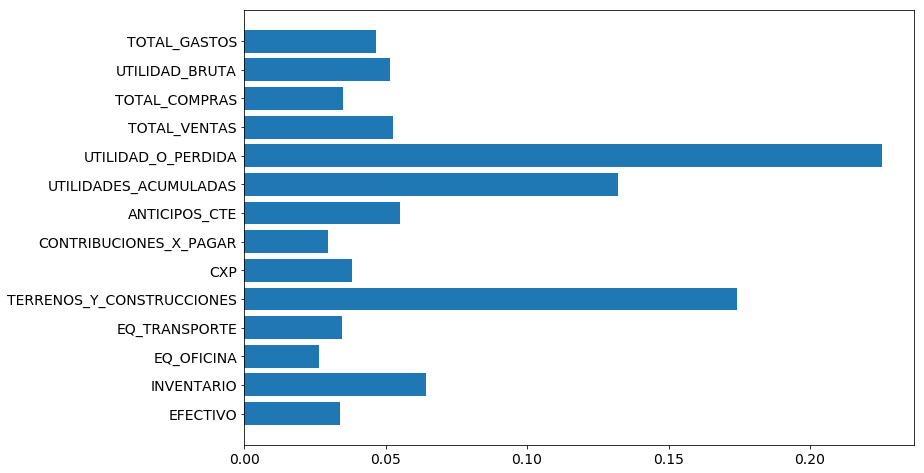

In [27]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

plt.barh(np.array(df3.columns)[:-1],
         dtc_model.feature_importances_)

#### Haciendo una predicción con el set de prueba

In [23]:
y_pred = dtc_model.predict(X_test)

#### Analizar la calidad del modelo a través de la matriz de confusión

In [24]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[80  7]
 [ 1 74]]
              precision    recall  f1-score   support

    Aceptado       0.99      0.92      0.95        87
  Sospechoso       0.91      0.99      0.95        75

    accuracy                           0.95       162
   macro avg       0.95      0.95      0.95       162
weighted avg       0.95      0.95      0.95       162

0.9506172839506173


Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.951\nPrecision=0.914\nRecall=0.987\nF1 Score=0.9487179487179487')

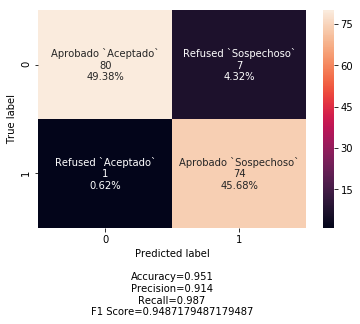

In [25]:
cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

##### ¡ATENCIÓN! Su puntuación en este desafío de clasificación se basará en la puntuación F1 del modelo al predecir el dataset de evaluación.

<hr>

## Puntuación de los datos necesarios para entregar la solución

Como entrega de su solución, esperamos que los resultados se clasifiquen en el siguiente conjunto de datos llamado "to_be_scored_compusoluciones.csv":

### Descarga la "hoja de evaluación"

In [28]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_compusoluciones.csv')
df_to_be_scored.tail()

--2020-09-05 23:37:46--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100124 (98K) [text/plain]
Saving to: ‘to_be_scored_compusoluciones.csv.3’

100%[======================================>] 100,124     --.-K/s   in 0.01s   

2020-09-05 23:37:47 (7.65 MB/s) - ‘to_be_scored_compusoluciones.csv.3’ saved [100124/100124]



,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
595,3.893725e+06,5.279410e+06,9.811669e+02,1.757291e+07,3.989011e+06,-1.545727e+07,2.497177e+06,103003.8264,2402813.337,NaN,1.751228e+07,-4050340.635,8.830412e+07,1.147548e+08,NaN,1.858752e+06
596,8.806031e+05,3.354813e+07,NaN,5.241604e+06,NaN,-1.727618e+06,4.021914e+07,821297.6732,3154291.078,NaN,1.636395e+07,-2394015.114,1.257229e+08,7.169861e+07,2.675382e+07,2.455403e+07
597,NaN,2.711050e+07,3.260820e+06,4.681080e+06,NaN,-3.291876e+06,3.763157e+07,NaN,1861471.266,942635.7885,7.126997e+06,NaN,6.531900e+07,1.014415e+08,2.333685e+07,NaN
598,7.443979e+06,4.076322e+07,6.408235e+06,1.507174e+07,6.257927e+05,-7.237902e+06,6.080636e+07,NaN,5220998.681,NaN,9.928204e+06,-3351032.988,9.340985e+07,1.571700e+08,3.062958e+07,3.042192e+07
599,5.611681e+05,6.438914e+06,3.867058e+06,4.545890e+05,1.949220e+06,-3.280783e+06,NaN,427294.9401,3954071.593,532328.4053,1.823676e+07,-5664180.434,1.059266e+08,5.820347e+07,5.238135e+05,2.470879e+06


# ¡Atención!

El Dataframe ``to_be_scored_compusoluciones`` es su "hoja de evaluación". Tenga en cuenta que a la columna "OBJETIVO" le faltan datos en este ejemplo, que luego no se pueden usar para entrenar modelos de aprendizaje supervisado.

In [ ]:
df_to_be_scored.info()

In [29]:
len(df_to_be_scored)

600

<hr>

# ¡Atención!

# Para aplicar su modelo y clasificar la hoja de evaluación, primero debe aplicar las mismas transformaciones de columnas que aplicó al conjunto de datos de entrenamiento.

# No elimine ni agregue líneas a la hoja de respuestas.

# No cambie el orden de las líneas en la hoja de respuestas.

# Al final, se deben clasificar las 600 entradas, con los valores calculados en la columna "target"

<hr>

En la celda de abajo, repetimos rápidamente los mismos pasos de preprocesamiento usados ​​en el ejemplo dado con el árbol de decisiones

In [30]:
rm_columns = DropColumns(
    columns=["CXC", "CAP_SOCIAL"]
)

print(rm_columns)

DropColumns(columns=['CXC', 'CAP_SOCIAL'])


In [31]:
# Aplicar la transformación ``DropColumns`` al conjunto de datos base
rm_columns.fit(X=df_to_be_scored)

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df_to_be_scored_2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df_to_be_scored
    ),
)

In [ ]:
df_to_be_scored_2.head()

In [32]:
# Crear un objeto ``SimpleImputer``
si =  SimpleImputer(
    missing_values=np.nan,
    strategy='mean',
)

si.fit(X=df_to_be_scored_2)

# Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df_to_be_scored_3 = pd.DataFrame.from_records(
    data=si.transform(
        X=df_to_be_scored_2
    ),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=df_to_be_scored_2.columns  # las columnas originales deben conservarse en esta transformación
)

In [33]:
df_to_be_scored_3.head()

,EFECTIVO,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS
0,1.402839e+06,17579093.50,1.648525e+06,5.027861e+05,1.050458e+06,5.314432e+07,2.076978e+06,5.822111e+06,1.180115e+07,-4.952369e+06,9.350929e+07,1.485613e+08,2.026458e+07,2.544413e+07
1,1.850961e+05,36407677.13,4.214732e+05,2.913787e+06,-1.751853e+06,2.387861e+07,7.095447e+04,2.403460e+06,9.051638e+06,-6.260910e+06,1.958889e+08,4.901225e+08,1.892297e+07,1.480940e+07
2,8.055658e+06,7723528.23,1.187192e+08,5.021466e+06,-1.197336e+07,8.172363e+07,9.482034e+05,2.056313e+07,9.041948e+06,-5.931161e+06,1.068589e+08,6.676051e+08,2.661718e+07,1.480940e+07
3,9.843232e+04,3991008.27,5.847962e+05,4.072740e+04,5.300208e+06,1.643472e+07,4.438788e+05,1.232947e+06,9.367407e+06,-4.511669e+06,1.068589e+08,1.593044e+08,9.875365e+06,6.535524e+06
4,1.744163e+06,36624028.71,4.719145e+06,3.222506e+06,-1.751853e+06,5.035698e+07,5.668446e+05,7.996380e+06,8.604879e+06,-1.924530e+05,3.397666e+08,9.354509e+07,1.511322e+07,2.903567e+07


In [ ]:
df_to_be_scored_3 = df_to_be_scored_3.drop(columns=['target'], axis=1)

In [34]:
# Realización de una prueba a ciegas en el modelo creado
y_pred = dtc_model.predict(df_to_be_scored_3)

In [35]:
# Agregando las respuestas en la columna "target"
df_to_be_scored_3['target'] = y_pred

In [36]:
print(Counter(y_pred))

Counter({'Sospechoso': 335, 'Aceptado': 265})


In [37]:
df_to_be_scored_3.head()

,EFECTIVO,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,target
0,1.402839e+06,17579093.50,1.648525e+06,5.027861e+05,1.050458e+06,5.314432e+07,2.076978e+06,5.822111e+06,1.180115e+07,-4.952369e+06,9.350929e+07,1.485613e+08,2.026458e+07,2.544413e+07,Sospechoso
1,1.850961e+05,36407677.13,4.214732e+05,2.913787e+06,-1.751853e+06,2.387861e+07,7.095447e+04,2.403460e+06,9.051638e+06,-6.260910e+06,1.958889e+08,4.901225e+08,1.892297e+07,1.480940e+07,Aceptado
2,8.055658e+06,7723528.23,1.187192e+08,5.021466e+06,-1.197336e+07,8.172363e+07,9.482034e+05,2.056313e+07,9.041948e+06,-5.931161e+06,1.068589e+08,6.676051e+08,2.661718e+07,1.480940e+07,Sospechoso
3,9.843232e+04,3991008.27,5.847962e+05,4.072740e+04,5.300208e+06,1.643472e+07,4.438788e+05,1.232947e+06,9.367407e+06,-4.511669e+06,1.068589e+08,1.593044e+08,9.875365e+06,6.535524e+06,Aceptado
4,1.744163e+06,36624028.71,4.719145e+06,3.222506e+06,-1.751853e+06,5.035698e+07,5.668446e+05,7.996380e+06,8.604879e+06,-1.924530e+05,3.397666e+08,9.354509e+07,1.511322e+07,2.903567e+07,Aceptado


### Guardar la hoja de respuestas como un archivo .csv para enviar
**SI YA TIENE UN DATA ASSET CON EL NOMBRE `results.csv` EN ESTE PROYECTO O EN OTRO PROYECTO DE WATSON STUDIO DEBE BORRAR EL ARCHIVO ANTES DE CORRER LA SIGUIENTE CELDA O TENDRA EL ERROR: _RuntimeError: File 'results.csv' already exists in storage._**

In [38]:
project.save_data(file_name="results.csv", data=df_to_be_scored_3.to_csv(index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'compusolucionesv2-donotdelete-pr-bodu5cikj8hxc9',
 'asset_id': '51a54f9d-7055-49cf-aeb6-eb38caf0eba1'}

# Atención

# La ejecución de la celda anterior creará un nuevo "data asset" en su proyecto de Watson Studio. Deberá descargar este archivo junto con este cuaderno y crear un archivo zip con **results.csv** y **notebook.ipynb** para enviarlo. (los archivos deben tener este nombre)

<hr>

## ¡Felicitaciones! 

Si ya está satisfecho con su solución, vaya a la página siguiente y envíe los archivos necesarios para su envío.

# https://compusoluciones.maratona.dev